In [ ]:
from pathlib import Path
from PIL import Image
from sklearn.utils import Bunch
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import seaborn as sns

2022-12-15 13:06:35.699898: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-15 13:06:35.700027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Importing the images & labelling the data

In [ ]:
train = '/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/'
test = '/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/'

In [ ]:
train_df = pd.read_csv('/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv')
test_df = pd.read_csv('/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
train_df['labels'] = LabelEncoder().fit_transform(train_df.label)

In [ ]:
train_df = train_df.rename({'filename':'Filename', 'label':'Activity Name', 'labels':'Labels'}, axis = 1)

In [ ]:
train_df.head()

,Filename,Activity Name,Labels
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14


In [ ]:
np.unique(train_df['Activity Name'])

array(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
       'fighting', 'hugging', 'laughing', 'listening_to_music', 'running',
       'sitting', 'sleeping', 'texting', 'using_laptop'], dtype=object)

In [ ]:
names = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
        'fighting', 'hugging', 'laughing', 'listening to music', 'running',
        'sitting', 'sleeping', 'texting', 'using laptop']

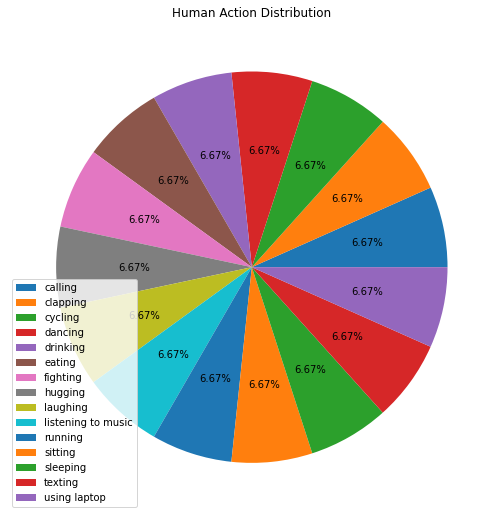

In [ ]:
plt.figure(figsize = (9, 9))
plt.pie(train_df.value_counts('Labels'), labels=None, autopct='%.2f%%')
plt.title("Human Action Distribution")
plt.legend(loc = 'lower left', labels = names)
plt.show()

#### Creating train and test sets

In [ ]:
X_im = []
for i in range(len(train_df)):
    X_im.append(os.path.join(train, train_df.iloc[i,0]))
X = np.array([np.array(Image.open(_).resize((128,128)))/255 for _ in X_im])
y = np.array(train_df.Labels)

In [ ]:
test_X_im = []
for i in range(len(test_df)):
    test_X_im.append(os.path.join(test, test_df.iloc[i,0]))
test_X = np.array([np.array(Image.open(_).resize((128,128)))/255 for _ in test_X_im])

In [ ]:
del(train, test, train_df, test_df)

In [ ]:
train_X, val_X = X[:10000], X[10000:]
train_y, val_y = y[:10000], y[10000:]

In [ ]:
train_X.shape, val_X.shape, test_X.shape

((10000, 128, 128, 3), (2600, 128, 128, 3), (5400, 128, 128, 3))

#### Plotting the images

In [ ]:
def plotting(n, m, data, labels, names):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,7))
    for _ in range(n):
        for __ in range(m):
            index = _*m + __
            plt.subplot(n, m, index + 1)
            plt.axis("off")
            plt.imshow(data[index], cmap="binary")
            plt.title(names[labels[index]], fontsize = 10)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

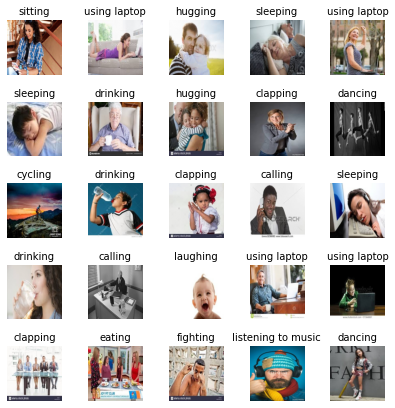

In [ ]:
plotting(5, 5, train_X, train_y, names)

#### Training our first model

In [ ]:
from functools import partial
convolution_layer = partial(keras.layers.Conv2D, kernel_size = 3, padding = 'same', strides = 1, activation = 'relu')

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
with tpu_strategy.scope():
    model1 = keras.models.Sequential()
    model1.add(convolution_layer(filters = 64, kernel_size=7, input_shape = [128, 128, 3]))
    model1.add(keras.layers.MaxPool2D(pool_size=2))
    model1.add(convolution_layer(filters = 128))
    model1.add(convolution_layer(filters = 128))
    model1.add(keras.layers.MaxPool2D(pool_size=2))
    model1.add(keras.layers.Flatten())
    model1.add(keras.layers.Dense(128, activation = 'relu'))
    model1.add(keras.layers.Dropout(0.25))
    model1.add(keras.layers.Dense(64, activation = 'relu'))
    model1.add(keras.layers.Dropout(0.25))
    model1.add(keras.layers.Dense(15, activation = 'softmax'))
    opt1 = keras.optimizers.Adam(learning_rate = 0.0001)
    model1.compile(optimizer=opt1, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

2022-12-15 13:09:51.864116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 13:09:51.948159: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-15 13:09:51.948246: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 13:09:51.948309: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c11c15bfefe2): /proc/driver/nvidia/version does not exist
2022-12-15 13:09:51.957093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [ ]:
fitted_model1 = model1.fit(train_X, train_y, epochs = 30, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

2022-12-15 13:10:00.664468: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 2.7019 - accuracy: 0.0809

2022-12-15 13:10:34.981520: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 511180800 exceeds 10% of free system memory.


313/313 [==============================] - 32s 74ms/step - loss: 2.7018 - accuracy: 0.0810 - val_loss: 2.5822 - val_accuracy: 0.1569
Epoch 2/30
313/313 [==============================] - 8s 24ms/step - loss: 2.5739 - accuracy: 0.1493 - val_loss: 2.4788 - val_accuracy: 0.2308
Epoch 3/30
313/313 [==============================] - 8s 25ms/step - loss: 2.4394 - accuracy: 0.2026 - val_loss: 2.3251 - val_accuracy: 0.2658
Epoch 4/30
313/313 [==============================] - 8s 25ms/step - loss: 2.3306 - accuracy: 0.2369 - val_loss: 2.2623 - val_accuracy: 0.2773
Epoch 5/30
313/313 [==============================] - 8s 25ms/step - loss: 2.1951 - accuracy: 0.2886 - val_loss: 2.2212 - val_accuracy: 0.2962
Epoch 6/30
313/313 [==============================] - 8s 25ms/step - loss: 2.0787 - accuracy: 0.3230 - val_loss: 2.1768 - val_accuracy: 0.2996
Epoch 7/30
313/313 [==============================] - 8s 25ms/step - loss: 1.9366 - accuracy: 0.3634 - val_loss: 2.1748 - val_accuracy: 0.3096
Epoch 8/3

In [ ]:
model1.evaluate(val_X, val_y)

2022-12-15 13:12:51.009913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 511180800 exceeds 10% of free system memory.


82/82 [==============================] - 2s 15ms/step - loss: 2.7500 - accuracy: 0.3004


[2.749971389770508, 0.30038464069366455]

##### We managed to reach 30% accuracy. It's much better than random guess, which is 1 out of 15.  
- Let's increase the number of convolutional layers

In [ ]:
with tpu_strategy.scope():
    model2 = keras.models.Sequential()
    model2.add(convolution_layer(filters = 64, kernel_size=7, input_shape = [128, 128, 3]))
    model2.add(keras.layers.MaxPool2D(pool_size=2))
    model2.add(convolution_layer(filters = 128))
    model2.add(convolution_layer(filters = 128))
    model2.add(keras.layers.MaxPool2D(pool_size=2))
    model2.add(convolution_layer(filters = 256))
    model2.add(convolution_layer(filters = 256))
    model2.add(keras.layers.MaxPool2D(pool_size=2))
    model2.add(keras.layers.Flatten())
    model2.add(keras.layers.Dense(128, activation = 'relu'))
    model2.add(keras.layers.Dropout(0.25))
    model2.add(keras.layers.Dense(64, activation = 'relu'))
    model2.add(keras.layers.Dropout(0.25))
    model2.add(keras.layers.Dense(15, activation = 'softmax'))
    opt2 = keras.optimizers.Adam(learning_rate = 0.0001)
    model2.compile(optimizer=opt2, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 256)      

In [ ]:
fitted_model2 = model2.fit(train_X, train_y, epochs = 30, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

2022-12-15 13:13:44.739553: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 2.6938 - accuracy: 0.0777

2022-12-15 13:14:15.595203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 511180800 exceeds 10% of free system memory.


313/313 [==============================] - 33s 74ms/step - loss: 2.6937 - accuracy: 0.0778 - val_loss: 2.5595 - val_accuracy: 0.1719
Epoch 2/30
313/313 [==============================] - 8s 24ms/step - loss: 2.5933 - accuracy: 0.1313 - val_loss: 2.4668 - val_accuracy: 0.1892
Epoch 3/30
313/313 [==============================] - 8s 24ms/step - loss: 2.5050 - accuracy: 0.1630 - val_loss: 2.4113 - val_accuracy: 0.2115
Epoch 4/30
313/313 [==============================] - 8s 24ms/step - loss: 2.4125 - accuracy: 0.2075 - val_loss: 2.2650 - val_accuracy: 0.2819
Epoch 5/30
313/313 [==============================] - 8s 24ms/step - loss: 2.2932 - accuracy: 0.2498 - val_loss: 2.2314 - val_accuracy: 0.2827
Epoch 6/30
313/313 [==============================] - 8s 24ms/step - loss: 2.2007 - accuracy: 0.2819 - val_loss: 2.1616 - val_accuracy: 0.3223
Epoch 7/30
313/313 [==============================] - 8s 24ms/step - loss: 2.0645 - accuracy: 0.3293 - val_loss: 2.0567 - val_accuracy: 0.3400
Epoch 8/3

In [ ]:
model2.evaluate(val_X, val_y)

82/82 [==============================] - 2s 14ms/step - loss: 2.7968 - accuracy: 0.3269


[2.7968251705169678, 0.32692310214042664]

#### 32.6% accuracy. 2% Increase from the previous model.
- Let's add one more Dense layer

In [ ]:
with tpu_strategy.scope():
    model3 = keras.models.Sequential()
    model3.add(convolution_layer(filters = 64, kernel_size=7, input_shape = [128, 128, 3]))
    model3.add(keras.layers.MaxPool2D(pool_size=2))
    model3.add(convolution_layer(filters = 128))
    model3.add(convolution_layer(filters = 128))
    model3.add(keras.layers.MaxPool2D(pool_size=2))
    model3.add(convolution_layer(filters = 256))
    model3.add(convolution_layer(filters = 256))
    model3.add(keras.layers.MaxPool2D(pool_size=2))
    model3.add(keras.layers.Flatten())
    model3.add(keras.layers.Dense(512, activation = 'relu'))
    model3.add(keras.layers.Dropout(0.25))
    model3.add(keras.layers.Dense(256, activation = 'relu'))
    model3.add(keras.layers.Dropout(0.25))
    model3.add(keras.layers.Dense(128, activation = 'relu'))
    model3.add(keras.layers.Dropout(0.25))
    model3.add(keras.layers.Dense(64, activation = 'relu'))
    model3.add(keras.layers.Dropout(0.25))
    model3.add(keras.layers.Dense(15, activation = 'softmax'))
    opt3 = keras.optimizers.Adam(learning_rate = 0.0001)
    model3.compile(optimizer=opt3, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
fitted_model3 = model3.fit(train_X, train_y, epochs = 30, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
313/313 [==============================] - 35s 80ms/step - loss: 2.7086 - accuracy: 0.0625 - val_loss: 2.6403 - val_accuracy: 0.1000
Epoch 2/30
313/313 [==============================] - 9s 29ms/step - loss: 2.6444 - accuracy: 0.1035 - val_loss: 2.5948 - val_accuracy: 0.1450
Epoch 3/30
313/313 [==============================] - 9s 30ms/step - loss: 2.5796 - accuracy: 0.1326 - val_loss: 2.4926 - val_accuracy: 0.1658
Epoch 4/30
313/313 [==============================] - 9s 30ms/step - loss: 2.5091 - accuracy: 0.1633 - val_loss: 2.4084 - val_accuracy: 0.1981
Epoch 5/30
313/313 [==============================] - 10s 30ms/step - loss: 2.4130 - accuracy: 0.1892 - val_loss: 2.3267 - val_accuracy: 0.2304
Epoch 6/30
313/313 [==============================] - 9s 30ms/step - loss: 2.3047 - accuracy: 0.2326 - val_loss: 2.2497 - val_accuracy: 0.2627
Epoch 7/30
313/313 [==============================] - 9s 30ms/step - loss: 2.1860 - accuracy: 0.2852 - val_loss: 2.1521 - val_accuracy: 0.30

In [ ]:
model3.evaluate(val_X, val_y)

82/82 [==============================] - 2s 15ms/step - loss: 3.9022 - accuracy: 0.3308


[3.902191162109375, 0.33076927065849304]

##### 33% accuracy. Not much different than the last model
- Let's remove one Dense layer

In [ ]:
with tpu_strategy.scope():
    model4 = keras.models.Sequential()
    model4.add(convolution_layer(filters = 64, kernel_size=7, input_shape = [128, 128, 3]))
    model4.add(keras.layers.MaxPool2D(pool_size=2))
    model4.add(convolution_layer(filters = 128))
    model4.add(convolution_layer(filters = 128))
    model4.add(keras.layers.MaxPool2D(pool_size=2))
    model4.add(convolution_layer(filters = 256))
    model4.add(convolution_layer(filters = 256))
    model4.add(keras.layers.MaxPool2D(pool_size=2))
    model4.add(keras.layers.Flatten())
    model4.add(keras.layers.Dense(256, activation = 'relu'))
    model4.add(keras.layers.Dropout(0.25))
    model4.add(keras.layers.Dense(128, activation = 'relu'))
    model4.add(keras.layers.Dropout(0.25))
    model4.add(keras.layers.Dense(64, activation = 'relu'))
    model4.add(keras.layers.Dropout(0.25))
    model4.add(keras.layers.Dense(15, activation = 'softmax'))
    opt4 = keras.optimizers.Adam(learning_rate = 0.0001)
    model4.compile(optimizer=opt4, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
fitted_model4 = model4.fit(train_X, train_y, epochs = 30, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
313/313 [==============================] - 34s 77ms/step - loss: 2.7092 - accuracy: 0.0711 - val_loss: 2.6844 - val_accuracy: 0.1015
Epoch 2/30
313/313 [==============================] - 8s 27ms/step - loss: 2.6757 - accuracy: 0.0930 - val_loss: 2.5709 - val_accuracy: 0.1335
Epoch 3/30
313/313 [==============================] - 8s 27ms/step - loss: 2.5971 - accuracy: 0.1256 - val_loss: 2.5017 - val_accuracy: 0.1569
Epoch 4/30
313/313 [==============================] - 8s 27ms/step - loss: 2.5411 - accuracy: 0.1533 - val_loss: 2.3954 - val_accuracy: 0.1915
Epoch 5/30
313/313 [==============================] - 8s 27ms/step - loss: 2.4710 - accuracy: 0.1747 - val_loss: 2.3853 - val_accuracy: 0.2062
Epoch 6/30
313/313 [==============================] - 8s 26ms/step - loss: 2.4044 - accuracy: 0.2027 - val_loss: 2.2763 - val_accuracy: 0.2446
Epoch 7/30
313/313 [==============================] - 8s 26ms/step - loss: 2.3136 - accuracy: 0.2340 - val_loss: 2.2101 - val_accuracy: 0.274

In [ ]:
model4.evaluate(val_X, val_y)

82/82 [==============================] - 2s 15ms/step - loss: 2.9610 - accuracy: 0.3508


[2.961033582687378, 0.3507692515850067]

##### We have managed to reach 35% accuracy with our custom model. Can we do better with a pre-trained model?

### EfficientNet Implementation

In [ ]:
# Resizing our images
X = np.array([np.array(Image.open(_).resize((224,224))) for _ in X_im])
test_X = np.array([np.array(Image.open(_).resize((224,224))) for _ in test_X_im])

In [ ]:
train_X, val_X = X[:10000], X[10000:]

##### First let's do transfer learning without changing any weights

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
with tpu_strategy.scope():
    inputs = keras.layers.Input(shape = (224, 224, 3))
    outputs = EfficientNetB0(include_top = False, weights='imagenet', drop_connect_rate = 0.4, pooling='max')(inputs)
    model5 = keras.Model(inputs, outputs)
    opt5 = keras.optimizers.Adamax(learning_rate = 0.001)
    model5.compile(optimizer = opt5, loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

In [ ]:
model5.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
fitted_model5 = model5.fit(train_X, train_y, epochs = 200, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
313/313 [==============================] - 117s 235ms/step - loss: 7.4410 - accuracy: 0.0029 - val_loss: 7.4567 - val_accuracy: 0.0123
Epoch 2/200
313/313 [==============================] - 14s 46ms/step - loss: 6.0643 - accuracy: 0.0531 - val_loss: 3.3627 - val_accuracy: 0.1362
Epoch 3/200
313/313 [==============================] - 15s 47ms/step - loss: 2.7825 - accuracy: 0.1066 - val_loss: 2.8423 - val_accuracy: 0.1504
Epoch 4/200
313/313 [==============================] - 15s 47ms/step - loss: 2.6770 - accuracy: 0.1266 - val_loss: 2.9278 - val_accuracy: 0.1546
Epoch 5/200
313/313 [==============================] - 15s 47ms/step - loss: 2.7265 - accuracy: 0.1133 - val_loss: 2.7326 - val_accuracy: 0.1635
Epoch 6/200
313/313 [==============================] - 15s 47ms/step - loss: 2.6951 - accuracy: 0.1182 - val_loss: 2.7222 - val_accuracy: 0.1581
Epoch 7/200
313/313 [==============================] - 15s 46ms/step - loss: 2.6957 - accuracy: 0.1225 - val_loss: 2.7011 - val_

In [ ]:
model5.evaluate(val_X, val_y)

82/82 [==============================] - 2s 21ms/step - loss: 1.9935 - accuracy: 0.5231


[1.9934862852096558, 0.5230769515037537]

##### Wow 52.3% accuracy! That's a high increase
- Now using EfficientNetB0, let's train a custom model

In [ ]:
with tpu_strategy.scope():
    ENB = EfficientNetB0(include_top = False, weights='imagenet', drop_connect_rate = 0.4, pooling='max', input_shape = (224, 224, 3))
    ENB.trainable = True        #unfreezing the pre-trained layers
    
    model_output = keras.layers.BatchNormalization()(ENB.output)
    model_output = keras.layers.Dense(256, activation = 'relu')(model_output)
    model_output = keras.layers.Dropout(0.25)(model_output)
    model_output = keras.layers.Dense(128, activation = 'relu')(model_output)
    model_output = keras.layers.Dropout(0.25)(model_output)
    outputs = keras.layers.Dense(15, activation = "softmax")(model_output)
    
    final_model = keras.Model(ENB.input, outputs)
    opt6 = keras.optimizers.Adamax(learning_rate = 0.001)
    final_model.compile(optimizer = opt6, loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

In [ ]:
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
____________________________________________________________________________________________

In [ ]:
fitted_final_model = final_model.fit(train_X, train_y, epochs = 40, validation_data = (val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/40
313/313 [==============================] - 117s 227ms/step - loss: 2.5607 - accuracy: 0.2090 - val_loss: 1.4086 - val_accuracy: 0.5512
Epoch 2/40
313/313 [==============================] - 15s 47ms/step - loss: 1.7702 - accuracy: 0.4430 - val_loss: 1.1578 - val_accuracy: 0.6481
Epoch 3/40
313/313 [==============================] - 15s 47ms/step - loss: 1.5360 - accuracy: 0.5184 - val_loss: 1.0674 - val_accuracy: 0.6827
Epoch 4/40
313/313 [==============================] - 15s 47ms/step - loss: 1.3564 - accuracy: 0.5822 - val_loss: 1.0770 - val_accuracy: 0.7069
Epoch 5/40
313/313 [==============================] - 15s 47ms/step - loss: 1.2579 - accuracy: 0.6224 - val_loss: 1.0565 - val_accuracy: 0.7288
Epoch 6/40
313/313 [==============================] - 15s 47ms/step - loss: 1.1187 - accuracy: 0.6588 - val_loss: 1.0735 - val_accuracy: 0.7304
Epoch 7/40
313/313 [==============================] - 15s 48ms/step - loss: 1.0885 - accuracy: 0.6668 - val_loss: 1.0749 - val_accurac

#### Plotting the loss and accuracy

<AxesSubplot:>

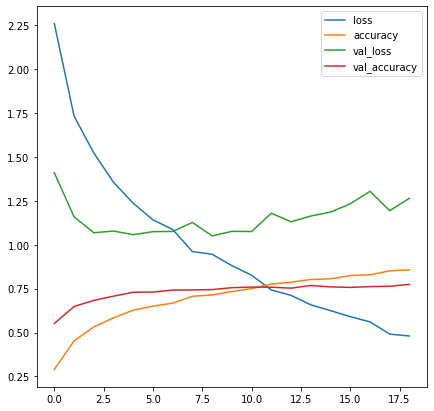

In [ ]:
pd.DataFrame(fitted_final_model.history).plot(figsize = (7,7))

In [ ]:
final_model.evaluate(val_X, val_y)

82/82 [==============================] - 2s 21ms/step - loss: 1.2636 - accuracy: 0.7738


[1.2636263370513916, 0.7738462090492249]

#### We've achieved 78% accuracy. That's more than double compared to our first model
- Calculating F-score

In [ ]:
from sklearn.metrics import classification_report
pred_val_y = np.argmax(final_model.predict(val_X), axis = 1)
print(classification_report(pred_val_y, val_y))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       198
           1       0.74      0.77      0.75       170
           2       0.93      0.98      0.95       162
           3       0.80      0.82      0.81       175
           4       0.72      0.83      0.77       145
           5       0.90      0.88      0.89       192
           6       0.80      0.80      0.80       182
           7       0.88      0.80      0.83       177
           8       0.74      0.78      0.76       146
           9       0.58      0.73      0.64       142
          10       0.83      0.79      0.81       187
          11       0.64      0.56      0.60       185
          12       0.88      0.78      0.83       182
          13       0.68      0.72      0.70       187
          14       0.74      0.72      0.73       170

    accuracy                           0.77      2600
   macro avg       0.77      0.78      0.77      2600
weighted avg       0.78   

#### Finally predicting the image labels from the test set

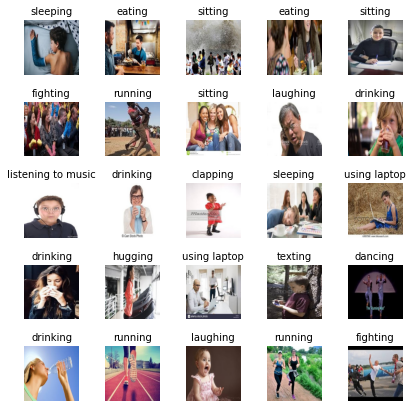

In [ ]:
pred_y = np.argmax(final_model.predict(test_X), axis = 1)
plotting(5, 5, test_X, pred_y, names)